# Water Quality Parameters

This notebook aims at computing the descriptive statistics for the WQP maps, or any raster, by defining specific features from which these statistics are requested (located within the [in](./in) folder). In addition, the analysis of the WQP maps will consider de extraction of sampling data inside the pixels to review the estimates.

In [1]:
# Styling notebook

# System
import os
import sys

# Import scripts libraries for the project
sys.path.append('./src/python')

# Import the function to update the notebook style
from nbConfig import (css_styling)

css_styling()

## 0. Import Libraries

In [2]:
# Data
import numpy as np
import pandas as pd

# Spatial Data
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show_hist
import ipywidgets as wg

# Import custom libraries
import wqpFunctions as wqp

Define the working directory for the WQP processing

In [3]:
# Current Working Directories
cwd = {
    'local': '.',
    'in': './in/data/wqp/',
    'out': './out/OutlierRejection',
    'vector': './vector',
}

Import the vector files for data extraction of the WQP maps

In [4]:
# Layer dataset
gdf_lakes = gpd.read_file(os.path.join(cwd['vector'],'simile_laghi','simile_laghi.shp'))
# Buoy position in the lake
gdf_buoy = gpd.read_file(os.path.join(cwd['vector'],'boa_sample_points','boa_sample_points.shp'))
# Random sampling points
gdf_sample = gpd.read_file(os.path.join(cwd['vector'],'random_points','random_points.shp'))

<AxesSubplot:>

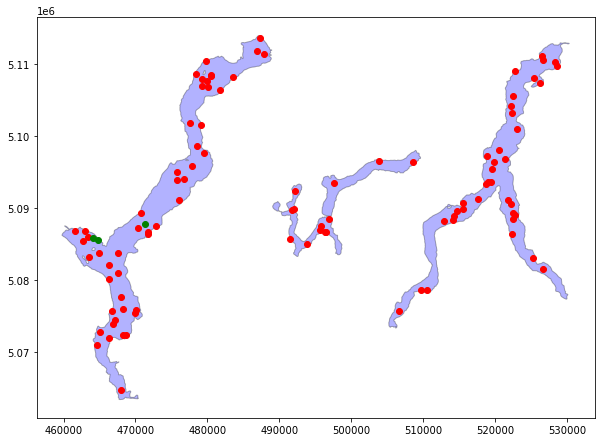

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_lakes.plot(ax = ax, color= 'blue', edgecolor='k', alpha = 0.3)
gdf_sample.plot(ax = ax, color='red')
gdf_buoy.plot(ax = ax, color='green')

Review the contents of the folder

### Select WQP and Outlier Rejection Method

In [6]:
SENSOR_LIST = ['S3','L8']
sensor = wg.Select(
    options = SENSOR_LIST,
    value = SENSOR_LIST[0],
    description = 'Select the sensor:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='20%', height='100px'),
)

In [7]:
WQP_LIST = ['chl','tsm','lswt']
wqpMaps = wg.Select(
    options = WQP_LIST,
    value = WQP_LIST[0],
    description = 'Select the wqp:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='15%', height='100px'),
)

In [8]:
OUTLIERS_METHOD_LIST = ['IQR','2Sigma','3Sigma']
outlierMethods = wg.Select(
    options = OUTLIERS_METHOD_LIST,
    value = OUTLIERS_METHOD_LIST[0],
    description = 'Select the outlier method:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='30%', height='100px'),
)

In [9]:
REF_PROD_LIST = ['wqp','wqp_cloud_mask','wqp_no_clip','wqp_no_mask','wqp_high_clouds','wqp_mid_high_clouds']#last 2 L8
refProducts = wg.Select(
    options = REF_PROD_LIST,
    value = REF_PROD_LIST[0],
    description = 'Select ref product:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='35%', height='100px'),
)

In [10]:
wg.HBox([sensor,wqpMaps, outlierMethods,refProducts])

## 1. WQP Descriptive Statistics and Sampling Points

In [ ]:
in_path = os.path.join(cwd['in'],sensor.value,refProducts.value,wqpMaps.value,'cropped')
out_path = os.path.join(cwd['out'],'wqp',outlierMethods.value, wqpMaps.value)
for root, dirs, files in os.walk(cwd['in']):
    for file in files[0:5]:
        if file.endswith('.tif'):
            print(file)
            f = os.path.join(cwd['in'],file)
            
            # Read file
            src = wqp.wqp(f)
            src.readWQP()
            src.name
            
            # Export dataset (check no data values)
#             t = src.image.read(1)
#             t = np.nan_to_num(t)
#             t[t<=0] = np.nan
#             src.writeWQP(cwd['out'],t)
            
            # Extract information from sampling points
#             src.extractSamplePoints(gdf_sample)
#             src.extractSamplePoints(gdf_buoy)
#             src.samplePoint.to_csv(os.path.join(cwd['out'],'sample_points',src.name+'.csv'))
            
            # Compute statistics for the lakes polygons
            src.computeStatistics(gdf_lakes, 'Nome',"count min mean max median std  percentile_25 percentile_50 percentile_75",0)
            
            # Format output
            df = wqp.wqp.exportWQPFormatStats(src)
            
            # Export the statistics result to a file (append data if existing)
            out_file = os.path.join(cwd['out'],'lakesStats_filtered.csv')
            if os.path.exists(out_file):
                df.to_csv(os.path.join(cwd['out'],'lakesStats_filtered.csv'),mode='a', header=False)
            else:
                df.to_csv(os.path.join(cwd['out'],'lakesStats_filtered.csv')) 

## 2. Outlier Rejection Methods

Create the outliers "free" maps based on the selected wqpMaps and otulierMethods selectedd above

In [13]:
in_path = os.path.join(cwd['in'],sensor.value,refProducts.value,wqpMaps.value,'cropped')
out_path = os.path.join(cwd['out'],'wqp',outlierMethods.value, wqpMaps.value)
for root, dirs, files in os.walk(in_path):
    for file in files[0:5]:
        if file.endswith('.tif'):
            print(in_path,file)
            f = os.path.join(in_path,file)
            
            # Read file
            src = wqp.wqp(f)
            src.readWQP()
            src.name
            
            # Crop the lakes by the lakes 
            src.cropRasterByFeatures(os.path.join(cwd['vector'],'simile_laghi','simile_laghi.shp'),'Nome')
            
            # Compute statistics for the lakes polygons
            src.computeStatistics(gdf_lakes, 'Nome',"count min mean max median std percentile_25 percentile_50 percentile_75",0)
            
            # Apply the outlier rejection method
            src.outlierRejection(method=outlierMethods.value, minLower=0)    
            
            # Export the outlier rejection products
            src.mergeRasterCollectionsExport(src.raster_collection, os.path.join(out_path, src.name + '.tif'))
            src.mergeRasterCollectionsExport(src.outliers_collection, os.path.join(out_path,'outliers', src.name + '.tif'))
            
            # Export outliers data
            df = wqp.wqp.exportWQPFormatStatsOutliers(src)
            
            # Export the statistics result to a file (append data if existing)
            out_file = os.path.join(out_path,'outliers',f'lakesStats_{outlierMethods.value}_{wqpMaps.value}.csv')
            if os.path.exists(out_file):
                df.to_csv(os.path.join(out_path,'outliers',f'lakesStats_{outlierMethods.value}_{wqpMaps.value}.csv'),mode='a', header=False)
            else:
                df.to_csv(os.path.join(out_path,'outliers',f'lakesStats_{outlierMethods.value}_{wqpMaps.value}.csv')) 

./in/data/wqp/S3\wqp\chl\cropped S3A_CHL_IT_20190215T100832_L1.tif
./in/data/wqp/S3\wqp\chl\cropped S3A_CHL_IT_20190315T094218_L1.tif
./in/data/wqp/S3\wqp\chl\cropped S3A_CHL_IT_20190322T100102_L1.tif
./in/data/wqp/S3\wqp\chl\cropped S3A_CHL_IT_20201124T100835_L1.tif


In [ ]:
src.__dict__

In [ ]:
src.outlierRejection(method='2Sigma', minLower=0, maxUpper=15)

In [ ]:
src.create_dataset(src.crops['Maggiore']['crop'][0],src.crops['Maggiore']['transform'])

In [ ]:
src.mergeRasterCollectionsExport('./test.tif')

In [ ]:
src.__dict__